In [1]:
#From SAV to LOVE

# HW№5

In [3]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random

from collections import Counter
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
import numpy as np
from sklearn import model_selection

## Задание №1

Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [4]:


classification_data, classification_labels = make_classification(n_samples=500, n_features = 2, 
                                                                 n_informative = 2, n_classes = 2, 
                                                                 n_redundant=0, n_clusters_per_class=1, random_state=17)

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [5]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
    return bootstrap

In [6]:
def get_subsample(len_sample):
    sample_indexes = [i for i in range(len_sample)]
    random.shuffle(sample_indexes)
    len_subsample = int(np.sqrt(len_sample))
    subsample = [sample_indexes.pop() for _ in range(len_subsample)]
    return subsample

In [7]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле


class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        classes = Counter(self.labels)
        return max(classes, key=classes.get)


In [8]:
def gini(labels):
    classes = Counter(labels)
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    return impurity

def quality(left_labels, right_labels, current_gini):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data, false_data = data[left], data[right]
    true_labels, false_labels = labels[left], labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    min_leaf = 5
    current_gini = gini(labels)
    best_quality, best_t, best_index = 0, None, None
    n_features = data.shape[1]

    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels):
    quality, t, index = find_best_split(data, labels)
    if quality == 0: return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)
    return Node(index, t, true_branch, false_branch)

In [11]:
def random_forest(data, labels, n_trees):
    bootstrap = get_bootstrap(data, labels, n_trees)
    return [build_tree(b_data, b_labels) for b_data, b_labels in bootstrap ]


In [12]:
def classify_object(obj, node):
    if isinstance(node, Leaf): return node.prediction
    branch = (node.true_branch if obj[node.index] <= node.t else node.false_branch)   
    return classify_object(obj, branch)


In [13]:
def predict(data, tree):
    return [classify_object(obj, tree) for obj in data]

def tree_vote(forest, data):
    predictions = [predict(data, tree) for tree in forest]
    predictions_per_object = list(zip(*predictions))
    voted_predictions = [max(set(obj), key=obj.count) for obj in predictions_per_object]
    return voted_predictions

In [14]:
#train_data, test_data, train_labels, test_labels
forest = [random_forest(train_data, train_labels, n)  for n in [1,3,10,50]]

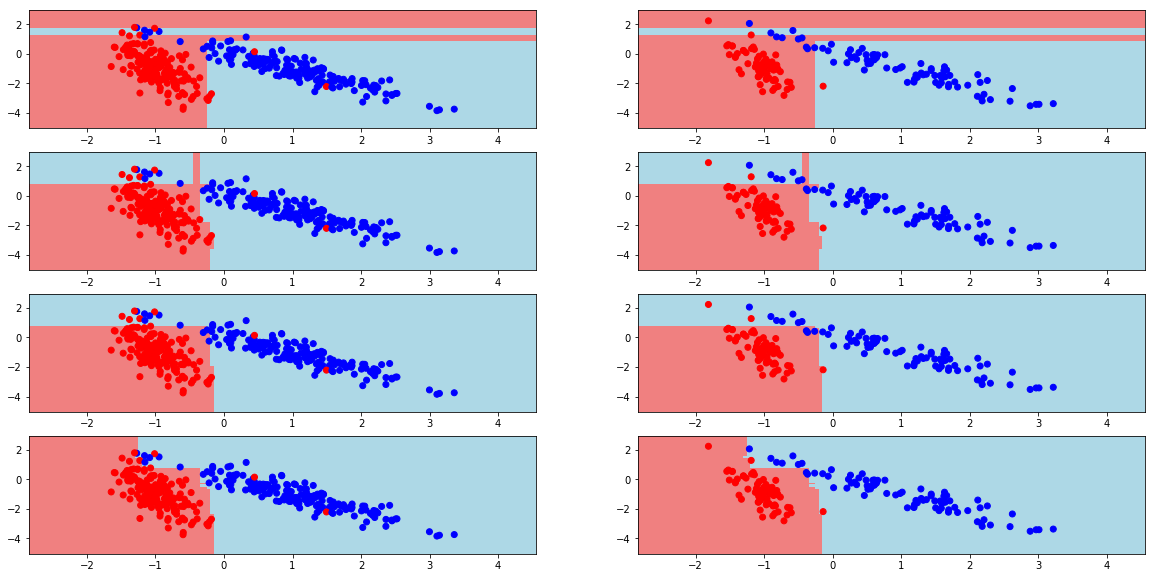

In [18]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize = (20, 10))

# график обучающей выборки
xx, yy = get_meshgrid(train_data)
idx = [i for i in range(1,9)] 
for f in range(len(forest)):
    plt.subplot(4,2,idx.pop(0))
    mesh_predictions = np.array(tree_vote(forest[f], np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)

    # график тестовой выборки
    plt.subplot(4,2,idx.pop(0))
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    
    



Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем. 

## Ответ

Глядя на график напрашивается вывод, о том что чем больше деревьев, тем более точно гиперплоскость отделяет классы друг от друга.
Чем меньше деревьев в лесу, тем выше вероятность переобучения.

## Задание №2*

Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

### Задание №3*

 (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.